<a href="https://colab.research.google.com/github/Tatianabeg/-/blob/main/DZ_8_gan_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. GAN.

GAN (Generative Adversarial Network) - семейство моделей, которые выучивают распределение над данными соревнованием (adversarial=состязательные) двух нейронных сетей:

1. Дискриминатор пытается отличить сгенерированные объекты от реальных.
2. Генератор пытается обмануть дискриминатор и сгенерировать такие объекты, которые он не сможет отличить от настоящих.

Задача, которую решают сети, является минимаксной (одна сеть пытается минимизировать функционал, а другая максимизировать) и её точка равновесия достигается, когда генератор выдает объекты, полностью не отличимые от настоящих.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

%matplotlib inline

from IPython.display import clear_output

device = "cuda:0"
torch.cuda.set_device(0)

## 2. Vanilla GAN.

Для Vanilla GAN функционал имеет следующий вид:


Процесс обучения GAN'а выглядит так:

In [ ]:
from typing import Optional

from typing_extensions import Literal


def gan_loss(
    real_objects_scores: torch.Tensor,
    generated_objects_scores: torch.Tensor,
    by: Literal["generator", "discriminator"] = "generator",
) -> torch.Tensor:
    """
    Имплементирует подсчет лосса для генератора и дискриминатора.
    """
    if by == "generator":
        # возвращает лосс генератора
        return  # YOUR CODE HERE
    elif by == "discriminator":
        # возвращает лосс дискриминатора
        return  # YOUR CODE HERE


def train_gan(
    tr_dataloader,
    gen,
    discr,
    gen_opt,
    discr_opt,
    loss_func,
    prior,
    num_epochs,
    gen_steps,
    discr_steps,
    discr_params_clip_value=None,
    verbose_num_iters=100,
    data_type="2d",
):
    """
    Имплементирует подсчет лосса для генератора и дискриминатора.
    """
    gen.train()
    discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f"Epoch {epoch_i + 1}")
        for batch in tr_dataloader:
            # берем реальные объекты
            real_objects, y = batch
            real_objects = real_objects.to(device)
            y = y.to(device)

            # генерируем новые объекты
            num_objects = real_objects.shape[0]
            z = prior.sample((num_objects,))
            gen_objects = gen(z, y)

            # считаем скоры
            real_objects_scores, gen_objects_scores = torch.split(
                discr(
                    torch.cat([real_objects, gen_objects], dim=0),
                    torch.cat([y, y], dim=0),
                ),
                num_objects,
            )

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
                # делаем шаг обучения генератора
                gen_opt.zero_grad()
                gen_loss = loss_func(
                    real_objects_scores, gen_objects_scores, "generator"
                )
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # делаем шаг обучения дискриминатора
                discr_opt.zero_grad()
                discr_loss = loss_func(
                    real_objects_scores, gen_objects_scores, "discriminator"
                )
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 3, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Generator loss")
                plt.plot([p[0] for p in gen_loss_trace], [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Discriminator loss")
                plt.plot(
                    [p[0] for p in discr_loss_trace],
                    [p[1] for p in discr_loss_trace],
                    color="orange",
                )

                gen.eval()
                if data_type == "2d":
                    plt.subplot(1, 3, 3)
                    with torch.no_grad():
                        z = prior.sample((1024,))
                        sampled_2d = gen(z)
                    x = real_objects.cpu().numpy()
                    plt.xlim(x.min(0)[0], x.max(0)[0])
                    plt.ylim(x.min(0)[1], x.max(0)[1])
                    plt.scatter(
                        sampled_2d[:, 0].cpu().detach().numpy(),
                        sampled_2d[:, 1].cpu().detach().numpy(),
                        s=1,
                    )
                elif data_type == "mnist":
                    with torch.no_grad():
                        z = prior.sample((100,))
                        sampled_mnist = gen(z, torch.arange(100).cuda() % 10)

                    for i in range(100):
                        plt.subplot(10, 30, 30 * (i // 10) + 21 + (i % 10))
                        plt.axis("off")
                        plt.imshow(
                            sampled_mnist[i, 0].detach().cpu().numpy(), cmap="gray"
                        )

                plt.show()
                gen.train()

    gen.eval()
    discr.eval()

### 2.1 GAN на 2d данных.

Давайте попробуем написать простые генератор и дискриминатор для генерации точек из 2d распределения.

In [ ]:
from sklearn import datasets

s_x, s_y = datasets.make_s_curve(n_samples=10000, noise=0.01)
s_x = s_x[:, [0, 2]]

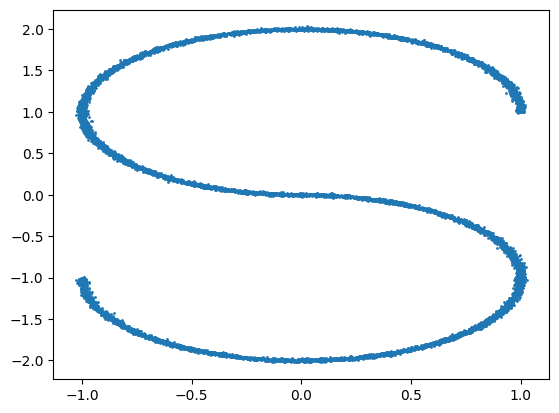

In [ ]:
plt.scatter(s_x[:, 0], s_x[:, 1], s=1)

In [ ]:
class Dataset2d:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

Теперь давайте обучим GAN

In [ ]:
class Generator2d(nn.Module):
    def __init__(self, lat_size: int = 2, out_size: int = 2, hid_size: int = 16):
        super(Generator2d, self).__init__()
        self.lat_size = lat_size
        self.net = nn.Sequential(
            nn.Linear(lat_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, out_size),
            nn.Tanh()  # В зависимости от задачи, может понадобиться иная функция активации
        )

    def forward(self, z: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
        '''
        Для батча латентных кодов z возвращает батч сгенерированных объектов
        '''
        return self.net(z)


In [ ]:
class Discriminator2d(nn.Module):
    def __init__(self, in_size: int = 2, hid_size: int = 16):
        super(Discriminator2d, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_size, hid_size),
            nn.LeakyReLU(0.2),  # Рекомендуется использовать LeakyReLU для дискриминатора
            nn.Linear(hid_size, hid_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hid_size, 1),
            nn.Sigmoid()  # Для бинарной классификации
        )

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> torch.Tensor:
        '''
        Для батча объектов возвращает их скоры.
        '''
        return self.net(x)


In [ ]:
# создадим сети, оптимизаторы, прайор и даталоадер

tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(s_x, dtype=torch.float32), torch.tensor(s_y)),
    batch_size=64,
    shuffle=True,
    num_workers=1,
)

gen_2d = Generator2d(hid_size=16)
gen_2d.cuda()

discr_2d = Discriminator2d(hid_size=16)
discr_2d.cuda()

prior_2d = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).cuda())

gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

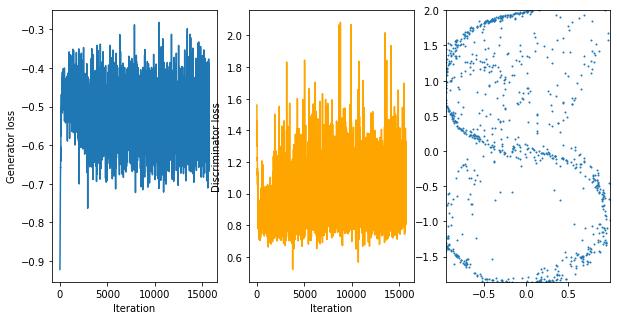

In [ ]:
# обучим  GAN


train_gan(
    tr_dataloader_2d,
    gen_2d,
    discr_2d,
    gen_opt_2d,
    discr_opt_2d,
    gan_loss,
    prior_2d,
    num_epochs=100,
    gen_steps=1,
    discr_steps=3,
    verbose_num_iters=100,
)

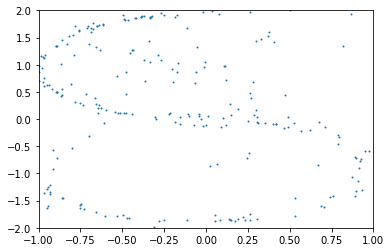

In [ ]:
# визуализируем получившееся распределение

z = prior_2d.sample((256,))

sampled_2d = gen_2d(z)

plt.xlim(-1, 1)
plt.ylim(-2, 2)

plt.scatter(
    sampled_2d[:, 0].cpu().detach().numpy(),
    sampled_2d[:, 1].cpu().detach().numpy(),
    s=1,
)

2d данные отлично подходят и для демонстрации слабых мест GAN'ов - когда данные состоят из нескольких мод (кластеров), ганы подверждены двум сценариям:
1. Mode collapse - ситуация, когда GAN игнорирует часть кластеров и не пытается их выучить.
2. Смешение мод - когда GAN соединяется две моды перешейком. Этот случай, как правило, решается взятием более мощного дискриминатора и генератора.

In [ ]:
circle_x, circle_y = datasets.make_circles(n_samples=10000, noise=0.01)

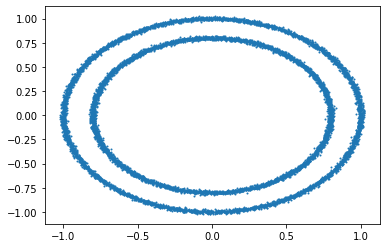

In [ ]:
plt.scatter(circle_x[:, 0], circle_x[:, 1], s=1)

In [ ]:
tr_dataloader_circle = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(circle_x, dtype=torch.float32), torch.tensor(circle_y)),
    batch_size=64,
    shuffle=True,
    num_workers=1,
)

gen_circle = Generator2d()
gen_circle.cuda()

discr_circle = Discriminator2d()
discr_circle.cuda()

prior_circle = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).cuda())

gen_opt_circle = optim.Adam(gen_circle.parameters(), lr=3e-4)
discr_opt_circle = optim.Adam(discr_circle.parameters(), lr=3e-4, betas=(0.9, 0.999))

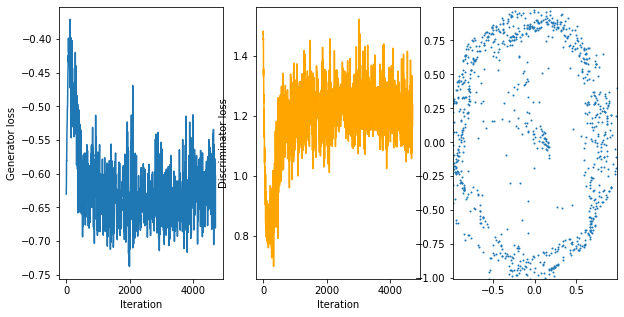

In [ ]:
train_gan(
    tr_dataloader_circle,
    gen_circle,
    discr_circle,
    gen_opt_circle,
    discr_opt_circle,
    gan_loss,
    prior_circle,
    num_epochs=30,
    gen_steps=1,
    discr_steps=3,
    verbose_num_iters=100,
)

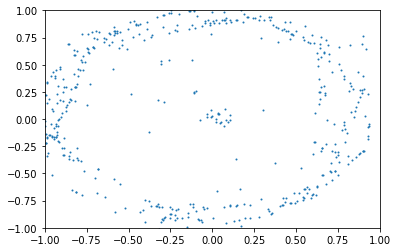

In [ ]:
z = prior_circle.sample((512,))

sampled_circle = gen_circle(z)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.scatter(
    sampled_circle[:, 0].cpu().detach().numpy(),
    sampled_circle[:, 1].cpu().detach().numpy(),
    s=1,
);

Выучилась только одна мода!